# 0. Imports

In [5]:
%load_ext autoreload
%autoreload 2

In [4]:
from functools import partial
import json
from pathlib import Path

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np

import demos.collas.datasets.dataloaders as dataloaders
import demos.collas.hparam_tune as hparam_tune
import demos.collas.run_classification_experiments as clf_experiments
import rebayes.utils.models as models

# 1. Stationary classification

In [ ]:
%env REBAYES_CONFIG=./configs/spectral_decay/

# Tune hyperparameters
%run ../run_classification_experiments.py --hyperparameter tune_only --ntrain 500\
    --n_explore 2 --n_exploit 2 --agents lofi --ranks 500 --mlp_features 5 5

In [17]:
model_init_fn = partial(models.initialize_classification_mlp,
                        hidden_dims=[5, 5,], input_dim = (1, 28, 28, 1),
                        output_dim = 10)
dataset = dataloaders.clf_datasets["stationary"]
dataset_load_fn, kwargs = dataset(ntrain=500).values()
dataset_load_fn = partial(dataset_load_fn, dataset_type="fashion_mnist")
dataset = dataset_load_fn(key=0)

In [18]:
stationary_hparams_path = Path(Path.cwd(), "configs", "spectral_decay", "stationary",
                               "fashion_mnist", "mlp", "nll")
with open(Path(stationary_hparams_path, "lofi-500.json"), "r") as f:
    stationary_hparams = json.load(f)

In [19]:
stationary_kwargs = {
    "memory_size": 500,
    "inflation": "hybrid",
    "lofi_method": "diagonal"
}
model_init_fn = partial(models.initialize_classification_mlp,
                        hidden_dims=[5, 5,])
stationary_optimizer_dict = hparam_tune.build_estimator(
    model_init_fn, stationary_hparams, "lofi-500", classification=True, 
    **stationary_kwargs
)

In [20]:
agent, init_cov = stationary_optimizer_dict["agent"], stationary_optimizer_dict["init_cov"]
model = model_init_fn(jr.PRNGKey(0))
X_train, *_, y_train = dataset["train"]
X_test, *_, y_test = dataset["test"]
test_kwargs = {"agent": agent, "X_test": X_test, "y_test": y_test, 
               "apply_fn": model["apply_fn"], "key": jr.PRNGKey(1), **kwargs}
stationary_posterior, _ = agent.scan(model["flat_params"], init_cov, X_train, y_train,
                                     callback=None, **kwargs)

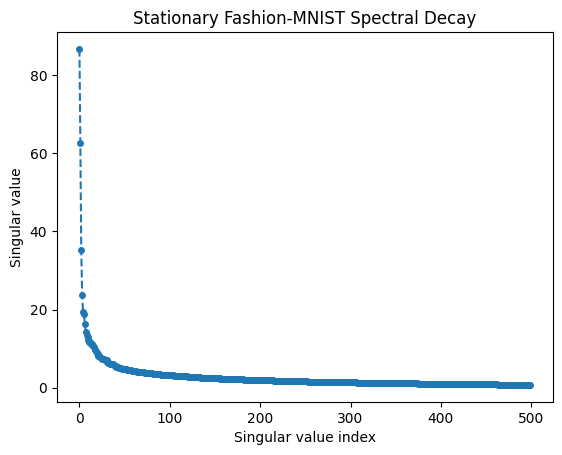

In [23]:
stationary_singular_values = stationary_posterior.svs

# Plot singular values in log scale in x axis
fig, ax = plt.subplots()
ax.plot(stationary_singular_values, marker="o", linestyle="--", ms=4);
# ax.set_xscale("log")
ax.set_xlabel("Singular value index")
ax.set_ylabel("Singular value")
ax.set_title("Stationary Fashion-MNIST Spectral Decay");

# 2. Permuted Classification

In [3]:
%env REBAYES_CONFIG=./configs/spectral_decay/

# Tune hyperparameters
%run ../run_classification_experiments.py --hyperparameter tune_only \
    --ntrain_per_task 50 --n_explore 2 --n_exploit 2 --agents lofi --ranks 500 \
        --mlp_features 5 5 --problem permuted

In [7]:
model_init_fn = partial(models.initialize_classification_mlp,
                        hidden_dims=[5, 5,], input_dim = (1, 28, 28, 1),
                        output_dim = 10)
dataset = dataloaders.clf_datasets["permuted"]
dataset_load_fn, kwargs = dataset(ntrain_per_task=50).values()
dataset_load_fn = partial(dataset_load_fn, dataset_type="fashion_mnist")
dataset = dataset_load_fn(key=0)

In [9]:
permuted_hparams_path = Path(Path.cwd(), "configs", "spectral_decay", "permuted",
                             "fashion_mnist", "mlp", "nll")
with open(Path(permuted_hparams_path, "lofi-500.json"), "r") as f:
    permuted_hparams = json.load(f)

In [11]:
permuted_kwargs = {
    "memory_size": 500,
    "inflation": "hybrid",
    "lofi_method": "diagonal"
}
model_init_fn = partial(models.initialize_classification_mlp,
                        hidden_dims=[5, 5,])
permuted_optimizer_dict = hparam_tune.build_estimator(
    model_init_fn, permuted_hparams, "lofi-500", classification=True, 
    **permuted_kwargs
)

In [12]:
agent, init_cov = permuted_optimizer_dict["agent"], permuted_optimizer_dict["init_cov"]
model = model_init_fn(jr.PRNGKey(0))
X_train, *_, y_train = dataset["train"]
X_test, *_, y_test = dataset["test"]
test_kwargs = {"agent": agent, "X_test": X_test, "y_test": y_test, 
               "apply_fn": model["apply_fn"], "key": jr.PRNGKey(1), **kwargs}
permuted_posterior, _ = agent.scan(model["flat_params"], init_cov, X_train, y_train,
                                   callback=None, **kwargs)

In [36]:
permuted_singular_values

Array([1.69422073e+01, 7.97461891e+00, 7.54262352e+00, 7.33755255e+00,
       7.13390827e+00, 6.84626389e+00, 6.75164318e+00, 6.65786314e+00,
       6.47607851e+00, 6.30964947e+00, 5.73041201e+00, 5.62845850e+00,
       4.50046444e+00, 4.07427788e+00, 4.03392601e+00, 3.32560253e+00,
       2.80665708e+00, 2.49458146e+00, 2.24880362e+00, 2.03048897e+00,
       1.94003332e+00, 1.85801303e+00, 1.76176691e+00, 1.73550367e+00,
       1.61368382e+00, 1.53931653e+00, 1.50559366e+00, 1.46835244e+00,
       1.37929654e+00, 1.34451032e+00, 1.20215726e+00, 1.15091610e+00,
       1.13995957e+00, 1.06715155e+00, 1.06457949e+00, 1.03462446e+00,
       9.93232846e-01, 9.74946260e-01, 8.82380068e-01, 8.24179828e-01,
       7.41536319e-01, 6.24136746e-01, 5.37700415e-01, 4.44853157e-02,
       4.41092625e-02, 4.24849279e-02, 4.18092422e-02, 4.05384302e-02,
       3.99857201e-02, 1.51838735e-03, 1.43896043e-03, 1.39320630e-03,
       1.39126985e-03, 1.32524699e-03, 1.32506259e-03, 1.31761329e-03,
      

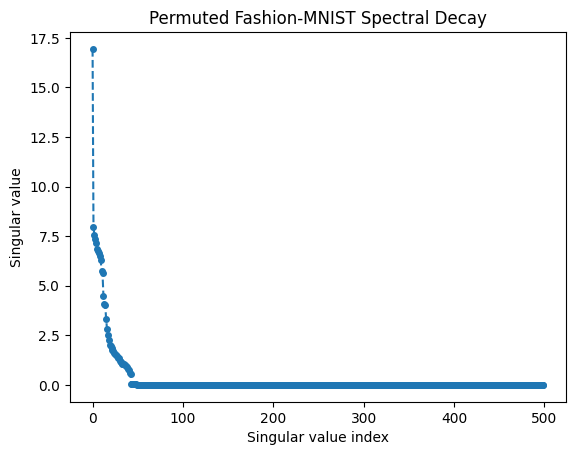

In [15]:
permuted_singular_values = permuted_posterior.svs

# Plot singular values in log scale in x axis
fig, ax = plt.subplots()
ax.plot(permuted_singular_values, marker="o", linestyle="--", ms=4);
# ax.set_xscale("log")
ax.set_xlabel("Singular value index")
ax.set_ylabel("Singular value")
ax.set_title("Permuted Fashion-MNIST Spectral Decay");

# 3. Rotated Classification

In [22]:
%env REBAYES_CONFIG=./configs/spectral_decay/

# Tune hyperparameters
%run ../run_classification_experiments.py --hyperparameter tune_only --ntrain 500\
    --n_explore 2 --n_exploit 2 --agents lofi --ranks 500 --mlp_features 5 5 \
        --problem rotated

In [24]:
model_init_fn = partial(models.initialize_classification_mlp,
                        hidden_dims=[5, 5,], input_dim = (1, 28, 28, 1),
                        output_dim = 10)
dataset = dataloaders.clf_datasets["rotated"]
dataset_load_fn, kwargs = dataset(ntrain=500).values()
dataset_load_fn = partial(dataset_load_fn, dataset_type="fashion_mnist")
dataset = dataset_load_fn(key=0)

In [25]:
rotated_hparams_path = Path(Path.cwd(), "configs", "spectral_decay", "rotated",
                            "fashion_mnist", "mlp", "nll")
with open(Path(rotated_hparams_path, "lofi-500.json"), "r") as f:
    rotated_hparams = json.load(f)

In [27]:
rotated_kwargs = {
    "memory_size": 500,
    "inflation": "hybrid",
    "lofi_method": "diagonal"
}
model_init_fn = partial(models.initialize_classification_mlp,
                        hidden_dims=[5, 5,])
rotated_optimizer_dict = hparam_tune.build_estimator(
    model_init_fn, rotated_hparams, "lofi-500", classification=True, 
    **rotated_kwargs
)

In [28]:
agent, init_cov = rotated_optimizer_dict["agent"], rotated_optimizer_dict["init_cov"]
model = model_init_fn(jr.PRNGKey(0))
X_train, *_, y_train = dataset["train"]
X_test, *_, y_test = dataset["test"]
test_kwargs = {"agent": agent, "X_test": X_test, "y_test": y_test, 
               "apply_fn": model["apply_fn"], "key": jr.PRNGKey(1), **kwargs}
rotated_posterior, _ = agent.scan(model["flat_params"], init_cov, X_train, y_train,
                                  callback=None, **kwargs)

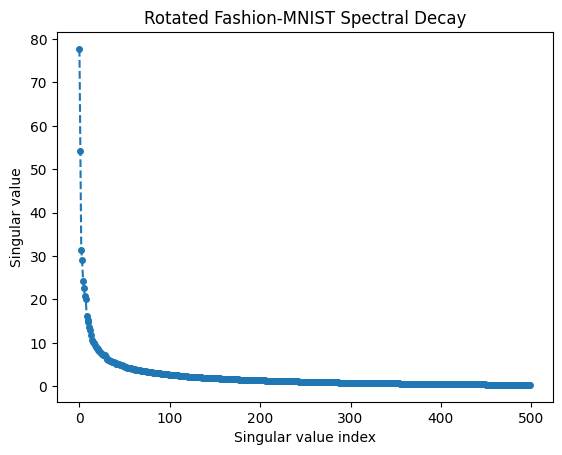

In [29]:
rotated_singular_values = rotated_posterior.svs

# Plot singular values in log scale in x axis
fig, ax = plt.subplots()
ax.plot(rotated_singular_values, marker="o", linestyle="--", ms=4);
# ax.set_xscale("log")
ax.set_xlabel("Singular value index")
ax.set_ylabel("Singular value")
ax.set_title("Rotated Fashion-MNIST Spectral Decay");

# 4. Spectral Decay Comparison

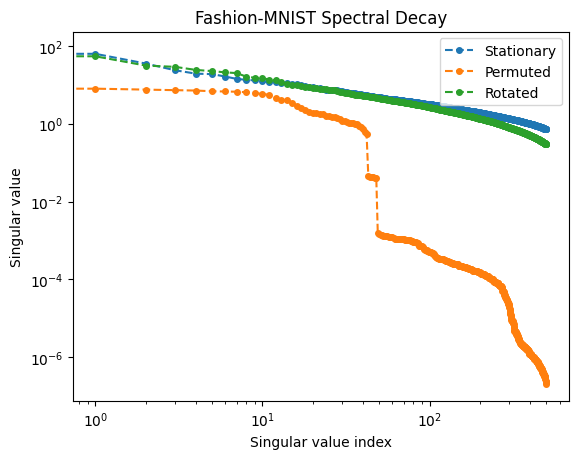

In [40]:
fig, ax = plt.subplots()
ax.plot(stationary_singular_values, marker="o", linestyle="--", ms=4, label="Stationary");
ax.plot(permuted_singular_values, marker="o", linestyle="--", ms=4, label="Permuted");
ax.plot(rotated_singular_values, marker="o", linestyle="--", ms=4, label="Rotated");
ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_ylim(0, 70)
ax.set_xlabel("Singular value index")
ax.set_ylabel("Singular value")
ax.set_title("Fashion-MNIST Spectral Decay")
ax.legend();